In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [8]:
current_directory = os.getcwd()
print(current_directory)

/Users/dori/Projects/battery-materials-dsbc25/modeling


In [9]:
feature_sets = []
feature_set_labels = []

# import three base feature sets
feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_PCA_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 PCs')
# ... rename principal component columns to be more descriptive
feature_sets[0] = feature_sets[0].rename(columns = dict([[str(i), 'stoich45 PC '+str(i+1)] for i in range(8)]))

feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_FeatureSelected_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 intersection')

feature_sets.append(pd.read_csv('../data/datasets_main/SCM_PCA_trainingStoich45_dataset.csv', sep=','))
feature_set_labels.append('SCM PCs')

# merge to form last two
feature_sets.append(feature_sets[0].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 PCs + SCM PCs')

feature_sets.append(feature_sets[1].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 intersection + SCM PCs')

# drop MOF column and rename target in all feature sets
feature_sets = [fs.drop(columns = ['MOF']).rename(columns = {'outputs.hse06.bandgap': 'HSE06 Bandgap'}) for fs in feature_sets]

In [11]:
target = 'HSE06 Bandgap'
kfold = KFold(n_splits = 4, shuffle = True, random_state = 1234)

def get_mean_cv_mse(model, df_feature_set):
    X = df_feature_set.drop(columns=[target])
    y = df_feature_set[target]
    scores = cross_val_score(
        model, X=X, y=y, cv=kfold, scoring='neg_mean_squared_error', n_jobs=4
    )
    return -scores.mean()

OLS Linear Regression

In [12]:
ols_cv_mse = np.zeros((len(feature_sets),))
print(f"{'Feature Set':<35}{'Cross-Validation MSE'}")

for (i, fs) in enumerate(feature_sets):
    ols_cv_mse[i] = get_mean_cv_mse(LinearRegression(),fs)
    print(f"{feature_set_labels[i]:<35}{round(ols_cv_mse[i],6)}")

Feature Set                        Cross-Validation MSE
Stoich45 PCs                       0.803314
Stoich45 intersection              0.685575
SCM PCs                            0.862338
Stoich45 PCs + SCM PCs             0.752578
Stoich45 intersection + SCM PCs    0.670345


Lasso Regression

/opt/anaconda3/envs/erdos/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+03, tolerance: 7.012e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e+03, tolerance: 7.177e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

Stoich45 PCs                        0.803312                  0.000774
Stoich45 intersection               0.68558                   0.0001
SCM PCs                             0.86552                   0.0001
Stoich45 PCs + SCM PCs              0.757543                  0.0001
Stoich45 intersection + SCM PCs     0.673476                  0.0001


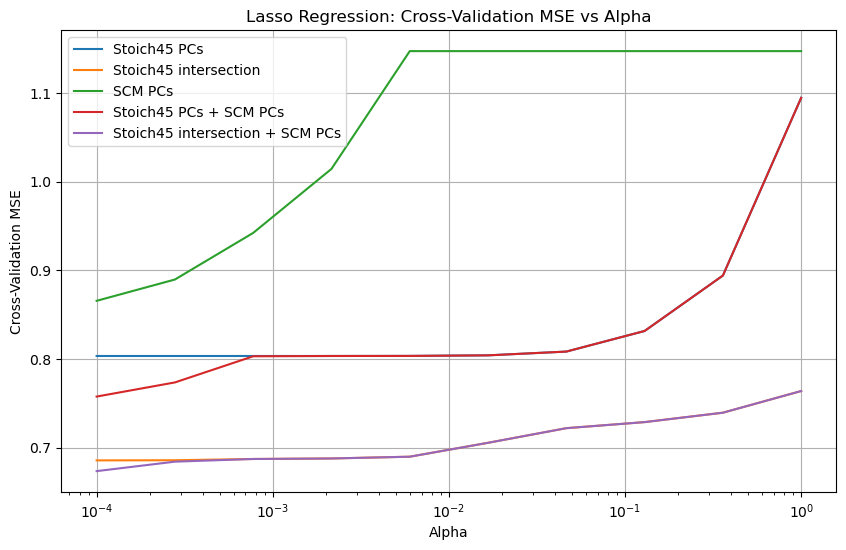

In [ ]:
lasso_alphas = np.logspace(-4, 0, 10)  # 10 values between 10^-4 and 10^0
lasso_optimal_alpha = np.zeros((len(feature_sets),))
lasso_cv_mse = np.zeros((len(feature_sets), len(lasso_alphas)))

for i, fs in enumerate(feature_sets):
    for j, alpha in enumerate(lasso_alphas):
        lasso_model = Lasso(alpha=alpha, max_iter=10000)
        lasso_cv_mse[i, j] = get_mean_cv_mse(lasso_model, fs)

plt.figure(figsize=(10, 6))

for i, label in enumerate(feature_set_labels):
    j_min = np.argmin(lasso_cv_mse[i])
    lasso_optimal_alpha[i] = lasso_alphas[j_min]
    
    print(f"{feature_set_labels[i]:<35} {round(lasso_cv_mse[i,j_min], 6):<25} {round(lasso_optimal_alpha[i],6)}")
        
    plt.plot(lasso_alphas, lasso_cv_mse[i, :], label=label)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation MSE')
plt.title('Lasso Regression: Cross-Validation MSE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()


Stoich45 PCs                        0.803314                  1.0
Stoich45 intersection               0.68556                   0.129155
SCM PCs                             0.862292                  0.002154
Stoich45 PCs + SCM PCs              0.752505                  0.005995
Stoich45 intersection + SCM PCs     0.670127                  0.005995


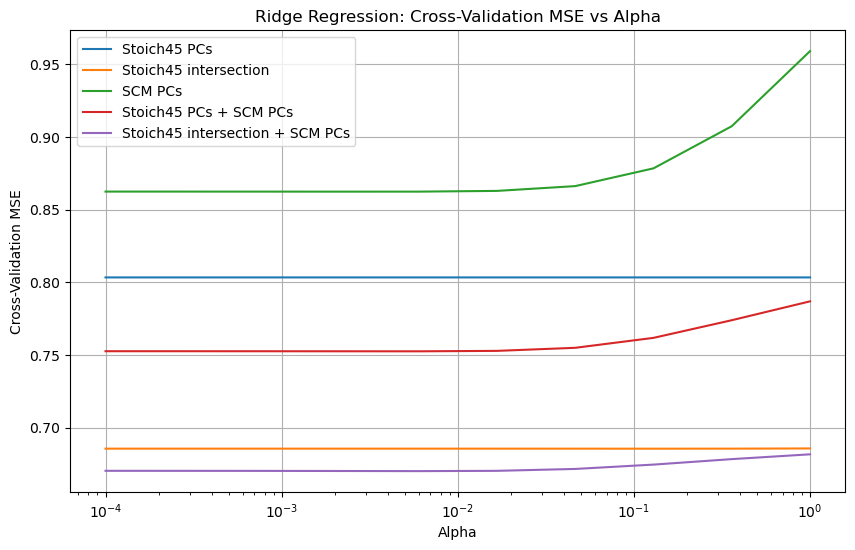

In [22]:
ridge_alphas = np.logspace(-4, 0, 10)  # 10 values between 10^-4 and 10^0
ridge_optimal_alpha = np.zeros((len(feature_sets),))
ridge_cv_mse = np.zeros((len(feature_sets), len(ridge_alphas)))

for i, fs in enumerate(feature_sets):
    for j, alpha in enumerate(ridge_alphas):
        ridge_model = Ridge(alpha=alpha, max_iter=10000)
        ridge_cv_mse[i, j] = get_mean_cv_mse(ridge_model, fs)

plt.figure(figsize=(10, 6))

for i, label in enumerate(feature_set_labels):
    j_min = np.argmin(ridge_cv_mse[i])
    ridge_optimal_alpha[i] = ridge_alphas[j_min]
    
    print(f"{feature_set_labels[i]:<35} {round(ridge_cv_mse[i,j_min], 6):<25} {round(ridge_optimal_alpha[i],6)}")
        
    plt.plot(ridge_alphas, ridge_cv_mse[i, :], label=label)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation MSE')
plt.title('Ridge Regression: Cross-Validation MSE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

## No difference between the MSE between the OLS, Lasso, Ridge.

/opt/anaconda3/envs/erdos/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+03, tolerance: 7.012e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+03, tolerance: 7.177e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

Stoich45 PCs                        0.803308                  Alpha: 0.005995, L1 Ratio: 0.1
Stoich45 intersection               0.685581                  Alpha: 0.0001, L1 Ratio: 0.9
SCM PCs                             0.875709                  Alpha: 0.0001, L1 Ratio: 0.9
Stoich45 PCs + SCM PCs              0.763246                  Alpha: 0.0001, L1 Ratio: 0.9
Stoich45 intersection + SCM PCs     0.675777                  Alpha: 0.0001, L1 Ratio: 0.9


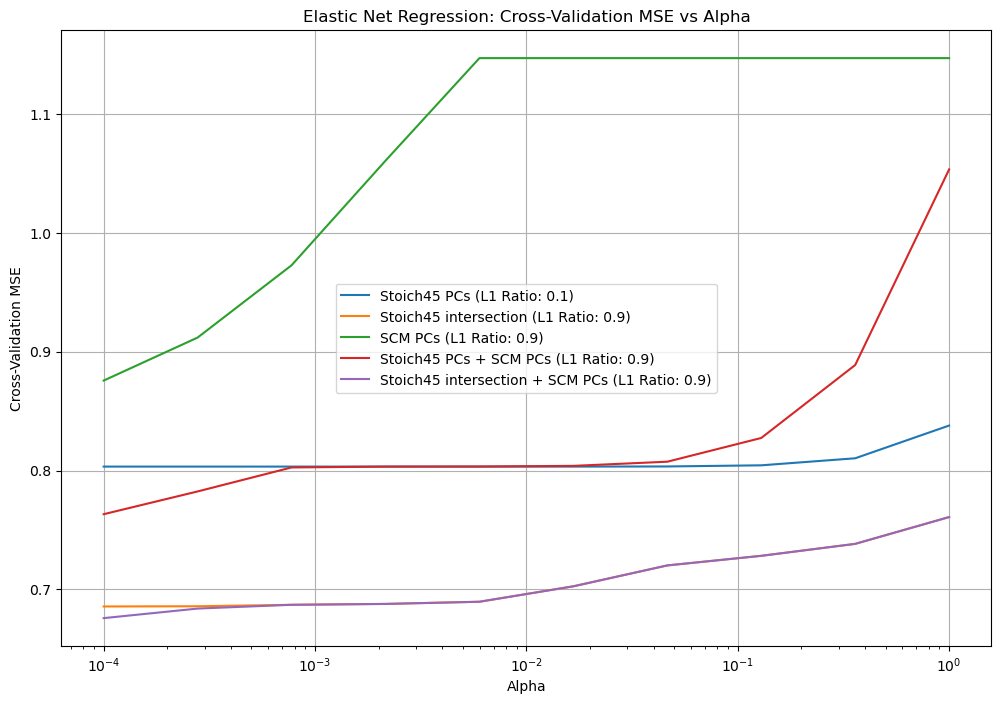

In [24]:
from sklearn.linear_model import ElasticNet

elastic_net_alphas = np.logspace(-4, 0, 10)  # 10 values between 10^-4 and 10^0
elastic_net_l1_ratios = np.linspace(0.1, 0.9, 9)  # 9 values between 0.1 and 0.9
elastic_net_optimal_params = np.zeros((len(feature_sets), 2))  # Store optimal alpha and l1_ratio
elastic_net_cv_mse = np.zeros((len(feature_sets), len(elastic_net_alphas), len(elastic_net_l1_ratios)))

for i, fs in enumerate(feature_sets):
    for j, alpha in enumerate(elastic_net_alphas):
        for k, l1_ratio in enumerate(elastic_net_l1_ratios):
            elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
            elastic_net_cv_mse[i, j, k] = get_mean_cv_mse(elastic_net_model, fs)

plt.figure(figsize=(12, 8))

for i, label in enumerate(feature_set_labels):
    min_idx = np.unravel_index(np.argmin(elastic_net_cv_mse[i]), elastic_net_cv_mse[i].shape)
    optimal_alpha, optimal_l1_ratio = elastic_net_alphas[min_idx[0]], elastic_net_l1_ratios[min_idx[1]]
    elastic_net_optimal_params[i] = [optimal_alpha, optimal_l1_ratio]
    
    print(f"{label:<35} {round(elastic_net_cv_mse[i][min_idx], 6):<25} Alpha: {round(optimal_alpha, 6)}, L1 Ratio: {round(optimal_l1_ratio, 2)}")
    
    plt.plot(elastic_net_alphas, elastic_net_cv_mse[i, :, min_idx[1]], label=f"{label} (L1 Ratio: {round(optimal_l1_ratio, 2)})")

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation MSE')
plt.title('Elastic Net Regression: Cross-Validation MSE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from xgboost import XGBRegressor

print(f"{'Feature Set':<35} {'Unimportant Features':<50} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=1234)
    X = fs.drop(columns=[target])
    y = fs[target]
    xgb_model.fit(X, y)
    
    # Get feature importances
    feature_importances = xgb_model.feature_importances_
    unimportant_features = X.columns[feature_importances == 0].to_list()
    
    # Calculate cross-validation MSE
    mse_cross = get_mean_cv_mse(xgb_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {str(unimportant_features):<50} {round(mse_cross, 6)}")

Feature Set                         Unimportant Features                               Cross-Validation MSE
Stoich45 PCs                        []                                                 0.655374
Stoich45 intersection               []                                                 0.561869
SCM PCs                             []                                                 0.850271
Stoich45 PCs + SCM PCs              []                                                 0.670104
Stoich45 intersection + SCM PCs     []                                                 0.58046


In [ ]:
from lightgbm import LGBMRegressor

print(f"{'Feature Set':<35} {'Unimportant Features':<50} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the LightGBM model
    lgbm_model = LGBMRegressor(objective='regression', random_state=1234)
    X = fs.drop(columns=[target])
    y = fs[target]
    lgbm_model.fit(X, y)
    
    # Get feature importances
    feature_importances = lgbm_model.feature_importances_
    unimportant_features = X.columns[feature_importances == 0].to_list()

    mse_cross = get_mean_cv_mse(lgbm_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {str(unimportant_features):<50} {round(mse_cross, 6)}")

Feature Set                         Unimportant Features                               Cross-Validation MSE
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8354, number of used features: 8
[LightGBM] [Info] Start training from score 3.846626
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6265, number of used features: 8
[LightGBM] [Info] Start training from score 3.837369
[LightGBM] [Warning] Found whitespace in feature_nam

In [32]:
from sklearn.tree import DecisionTreeRegressor

print(f"{'Feature Set':<35} {'Unimportant Features':<50} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the Decision Tree model
    dt_model = DecisionTreeRegressor(random_state=1234)
    X = fs.drop(columns=[target])
    y = fs[target]
    dt_model.fit(X, y)
    
    # Get feature importances
    feature_importances = dt_model.feature_importances_
    unimportant_features = X.columns[feature_importances == 0].to_list()
    
    # Calculate cross-validation MSE
    mse_cross = get_mean_cv_mse(dt_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {str(unimportant_features):<50} {round(mse_cross, 6)}")

Feature Set                         Unimportant Features                               Cross-Validation MSE
Stoich45 PCs                        []                                                 1.164165
Stoich45 intersection               []                                                 0.998591
SCM PCs                             []                                                 1.632817
Stoich45 PCs + SCM PCs              []                                                 1.257102
Stoich45 intersection + SCM PCs     []                                                 1.071746



 **Decision Tree Performance**:
    - Not good model choice

In [33]:
from sklearn.ensemble import RandomForestRegressor

print(f"{'Feature Set':<35} {'Unimportant Features':<50} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the Random Forest model
    rf_model = RandomForestRegressor(random_state=1234, n_estimators=100)
    X = fs.drop(columns=[target])
    y = fs[target]
    rf_model.fit(X, y)
    
    # Get feature importances
    feature_importances = rf_model.feature_importances_
    unimportant_features = X.columns[feature_importances == 0].to_list()
    
    # Calculate cross-validation MSE
    mse_cross = get_mean_cv_mse(rf_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {str(unimportant_features):<50} {round(mse_cross, 6)}")

Feature Set                         Unimportant Features                               Cross-Validation MSE
Stoich45 PCs                        []                                                 0.610142
Stoich45 intersection               []                                                 0.535771
SCM PCs                             []                                                 0.778508
Stoich45 PCs + SCM PCs              []                                                 0.624364
Stoich45 intersection + SCM PCs     []                                                 0.548362


In [34]:
from sklearn.ensemble import AdaBoostRegressor

print(f"{'Feature Set':<35} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the AdaBoost model
    ada_model = AdaBoostRegressor(random_state=1234, n_estimators=100)
    mse_cross = get_mean_cv_mse(ada_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {round(mse_cross, 6)}")

Feature Set                         Cross-Validation MSE
Stoich45 PCs                        1.060724
Stoich45 intersection               0.947921
SCM PCs                             0.949652
Stoich45 PCs + SCM PCs              1.014763
Stoich45 intersection + SCM PCs     0.94417


In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor

print(f"{'Feature Set':<35} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the Histogram-based Gradient Boosting model
    hist_gb_model = HistGradientBoostingRegressor(random_state=1234)
    mse_cross = get_mean_cv_mse(hist_gb_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {round(mse_cross, 6)}")

Feature Set                         Cross-Validation MSE
Stoich45 PCs                        0.61846
Stoich45 intersection               0.5221
SCM PCs                             0.77528
Stoich45 PCs + SCM PCs              0.621731
Stoich45 intersection + SCM PCs     0.53503


In [36]:
from sklearn.neighbors import KNeighborsRegressor

print(f"{'Feature Set':<35} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the KNN model
    knn_model = KNeighborsRegressor(n_neighbors=5)  # Using 5 neighbors as default
    mse_cross = get_mean_cv_mse(knn_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {round(mse_cross, 6)}")

Feature Set                         Cross-Validation MSE
Stoich45 PCs                        0.683029
Stoich45 intersection               0.698973
SCM PCs                             0.897325
Stoich45 PCs + SCM PCs              0.682806
Stoich45 intersection + SCM PCs     0.699215


In [ ]:
from sklearn.svm import SVR

print(f"{'Feature Set':<35} {'Cross-Validation MSE'}")

for i, fs in enumerate(feature_sets):
    # Train the SVR model
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Using RBF kernel as default
    mse_cross = get_mean_cv_mse(svr_model, fs)
    
    print(f"{feature_set_labels[i]:<35} {round(mse_cross, 6)}")

Feature Set                         Cross-Validation MSE
Stoich45 PCs                        0.63584
Stoich45 intersection               0.810716
SCM PCs                             0.778951
Stoich45 PCs + SCM PCs              0.635657
Stoich45 intersection + SCM PCs     0.813523


In [ ]:
# Create a dictionary to store the results
results = {
    'Feature Set': feature_set_labels,
    'OLS CV MSE': ols_cv_mse,
    'Lasso CV MSE': lasso_cv_mse.min(axis=1),  # Minimum MSE for each feature set
    'Lasso Optimal Alpha': lasso_optimal_alpha,
    'Ridge CV MSE': ridge_cv_mse.min(axis=1),  # Minimum MSE for each feature set
    'Ridge Optimal Alpha': ridge_optimal_alpha,
    'ElasticNet CV MSE': [elastic_net_cv_mse[i].min() for i in range(len(feature_sets))],  # Minimum MSE for each feature set
    'ElasticNet Optimal Alpha': elastic_net_optimal_params[:, 0],
    'ElasticNet Optimal L1 Ratio': elastic_net_optimal_params[:, 1],
    'XGBoost CV MSE': [get_mean_cv_mse(xgb_model, fs) for fs in feature_sets],
    'LightGBM CV MSE': [get_mean_cv_mse(lgbm_model, fs) for fs in feature_sets],
    'Decision Tree CV MSE': [get_mean_cv_mse(dt_model, fs) for fs in feature_sets],
    'Random Forest CV MSE': [get_mean_cv_mse(rf_model, fs) for fs in feature_sets],
    'AdaBoost CV MSE': [get_mean_cv_mse(ada_model, fs) for fs in feature_sets],
    'HistGradientBoosting CV MSE': [get_mean_cv_mse(hist_gb_model, fs) for fs in feature_sets],
    'KNN CV MSE': [get_mean_cv_mse(knn_model, fs) for fs in feature_sets],
    'SVR CV MSE': [get_mean_cv_mse(svr_model, fs) for fs in feature_sets],
}


results_df = pd.DataFrame(results)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6265, number of used features: 8
[LightGBM] [Info] Start training from score 3.837369
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6265, number of used features: 8
[LightGBM] [Info] Start training from score 3.865473
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

In [ ]:

output_dir = '../data/results'
os.makedirs(output_dir, exist_ok=True)
results_df.to_csv('../data/results/feature_set_comparison_results_dt.csv', index=False)

In [49]:
results_df

,Feature Set,OLS CV MSE,Lasso CV MSE,Lasso Optimal Alpha,Ridge CV MSE,Ridge Optimal Alpha,ElasticNet CV MSE,ElasticNet Optimal Alpha,ElasticNet Optimal L1 Ratio,XGBoost CV MSE,LightGBM CV MSE,Decision Tree CV MSE,Random Forest CV MSE,AdaBoost CV MSE,HistGradientBoosting CV MSE,KNN CV MSE,SVR CV MSE
0,Stoich45 PCs,0.803314,0.803312,0.000774,0.803314,1.000000,0.803308,0.005995,0.1,0.655374,0.612160,1.164165,0.610142,1.060724,0.618460,0.683029,0.635840
1,Stoich45 intersection,0.685575,0.685580,0.000100,0.685560,0.129155,0.685581,0.000100,0.9,0.561869,0.519493,0.998591,0.535771,0.947921,0.522100,0.698973,0.810716
2,SCM PCs,0.862338,0.865520,0.000100,0.862292,0.002154,0.875709,0.000100,0.9,0.850271,0.775725,1.632817,0.778508,0.949652,0.775280,0.897325,0.778951
3,Stoich45 PCs + SCM PCs,0.752578,0.757543,0.000100,0.752505,0.005995,0.763246,0.000100,0.9,0.670104,0.625116,1.257102,0.624364,1.014763,0.621731,0.682806,0.635657
4,Stoich45 intersection + SCM PCs,0.670345,0.673476,0.000100,0.670127,0.005995,0.675777,0.000100,0.9,0.580460,0.533666,1.071746,0.548362,0.944170,0.535030,0.699215,0.813523


In [ ]:

optimal_mse = results_df.filter(like='MSE').min().min()

optimal_model_column = results_df.filter(like='MSE').min().idxmin()
optimal_feature_set = results_df.loc[results_df[optimal_model_column].idxmin(), 'Feature Set']

optimal_model_name = optimal_model_column.replace(' CV MSE', '')

print(f"Optimal Model: {optimal_model_name}")
print(f"Feature Set: {optimal_feature_set}")
print(f"Optimal Cross-Validation MSE: {optimal_mse}")



Optimal Model: LightGBM
Feature Set: Stoich45 intersection
Optimal Cross-Validation MSE: 0.5194927234040412


In [53]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 100],
    'max_depth': [-1, 5, 10, 15],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the LightGBM model
lgbm = LGBMRegressor(objective='regression', random_state=1234)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=kfold,
    random_state=1234,
    n_jobs=-1
)

# Fit the random search on the dataset
random_search.fit(X, y)

# Print the best parameters and the corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation MSE:", -random_search.best_score_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9142
[LightGBM] [Info] Number of data points in the train set: 6266, number of used features: 40
[LightGBM] [Info] Start training from score 3.841976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9140
[LightGBM] [Info] Number of data points in the train set: 6265, number of used features: 40
[LightGBM] [Info] Start training from score 3.865473
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underline